# LHII Dimers

In [26]:
import re
import glob
import json
import pickle
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 100000)  # or 199

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

import read_gaussian

In [27]:
def get_centre(file_name):
    lines = list(open(file_name))
    
    for line in lines:
        if "Mg" in line:
            return 1.88973 * np.array([float(x) for x in re.findall(r'-?\d+.\d+', line)])

def read_exciton_file(file):
    eigenvalues = []
    coupling = None
    distance = None
    
    with open(file) as f:
        lines = f.readlines()    
    
    for enum, line in enumerate(lines):
        if "eigenvalues" in line:
            eigenvalues = [float(x[0]) for x in [re.findall(r'-?\d+.\d+', line) for line in lines[enum+2:enum+5]]]
            
        if "coupling energies" in line:
            coupling = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
        if "distances" in line:
            distance = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
    return eigenvalues, coupling, distance
        
def read_bchla_xtb(i, j, frame, file):
    monomerA = f"monomer_xyzs/trunc_bchla_{i}_frame_{frame}.xyz"
    monomerB = f"monomer_xyzs/trunc_bchla_{j}_frame_{frame}.xyz"
    
    centreA = get_centre(monomerA)
    centreB = get_centre(monomerB)
    
    distance = np.linalg.norm(centreA - centreB)
    
    eigenvalues, coupling, charge_centre_distance = read_exciton_file(file)
    
    
    return distance, eigenvalues, coupling, charge_centre_distance

def make_results_df():
    ring_assingments = json.load(open("ring_assignment.json"))
    assign_ring = lambda i : ring_assingments["rings"][f"{i}"]
    
    monomerAs = []
    monomerBs = []
    ringAs = []
    ringBs = []
    frames = []
    
    distances = []
    charge_centre_distances = []
    
    bchla_xtb_states = []
    bchla_xtb_transitions= []
    
    couplings = []

    CAMB3LYP_states = []
    CAMB3LYP_transitions = []
    
    for file in glob.glob("Exciton_Bchla_xTB/*.out"):
        ints = [int(x) for x in re.findall(r'\d+', file)]
        a, b = ints[:-1]
        frame = ints[2]
        
        if frame == 101:
            continue
        
        distance, eigenvalues, coupling, charge_centre_distance = read_bchla_xtb(a, b, frame, file)
        
        try:
            CAMB3LYP_results = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{a}_bchla_{b}_frame_{frame}.log")

        except:
            CAMB3LYP_states.append([None, None, None])
            CAMB3LYP_transitions.append([None, None])
        else:
            CAMB3LYP_states.append([CAMB3LYP_results.total_energy, CAMB3LYP_results.state_energies[0], CAMB3LYP_results.state_energies[1]])
            CAMB3LYP_transitions.append(CAMB3LYP_results.excitations[0:2])

        distances.append(distance)
        charge_centre_distances.append(charge_centre_distance)
        
        bchla_xtb_states.append(eigenvalues)
        bchla_xtb_transitions.append([round(x - eigenvalues[0], 6) for x in eigenvalues[1:]])
        couplings.append(abs(coupling))
                
        monomerAs.append(a)
        monomerBs.append(b)
        ringAs.append(assign_ring(a))
        ringBs.append(assign_ring(b))
            
        frames.append(frame)
        
    CAMB3LYP_present = [x[0]!=None for x in CAMB3LYP_states]
        
    return pd.DataFrame.from_dict({
    "monomer A" : np.array(monomerAs),
    "monomer B" : np.array(monomerBs),
    "ring A" : ringAs,
    "ring B" : ringBs,
    "frame" : np.array(frames),
    "distance" : np.array(distances),
    "charge_centre_distance" : np.array(charge_centre_distances),
    "coupling" : couplings,
    "exciton states" : bchla_xtb_states,
    "exciton transitions" : bchla_xtb_transitions,
    "CAMB3LYP states" : CAMB3LYP_states,
    "CAMB3LYP transitions" : CAMB3LYP_transitions,
    "CAMB3LYP present" : CAMB3LYP_present
    })

In [28]:
full_LHII_dimers = make_results_df()

In [96]:
LHII_dimers = full_LHII_dimers.loc[full_LHII_dimers["CAMB3LYP present"]]
LHII_dimers = LHII_dimers.sort_values(by="distance")

In [97]:
def get_values(series, i):
    return np.array([x[i] for x in series])

def assign_transitions(df):
    #this is probably wrong
    
    camb3lyp_transitions = [get_values(LHII_dimers["CAMB3LYP transitions"], 0), get_values(LHII_dimers["CAMB3LYP transitions"], 1)]
    exciton_transitions  = [get_values(LHII_dimers["exciton transitions"], 0), get_values(LHII_dimers["exciton transitions"], 1)]
    
    distances = LHII_dimers["distance"].to_numpy()
    
    assigned_camb3lyp_transitions = []
    assigned_exciton_transitions = []
    all_distances = []
    
    for enum, trns in enumerate(camb3lyp_transitions[0]):
        
        same_index = abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum])
        opps_index = abs(camb3lyp_transitions[1][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[1][enum])
        
        if(same_index < opps_index):
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            
        elif(opps_index < same_index):
            print(round(camb3lyp_transitions[0][enum], 4), round(camb3lyp_transitions[1][enum], 4))
            print(exciton_transitions[0][enum], exciton_transitions[1][enum])
            print()
            
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
        
        all_distances.append(distances[enum])
        all_distances.append(distances[enum])
        
    assert(len(assigned_camb3lyp_transitions) == len(assigned_exciton_transitions))
    assert(len(assigned_camb3lyp_transitions) == len(all_distances))
    
    return assigned_camb3lyp_transitions, assigned_exciton_transitions, all_distances

## By Distance

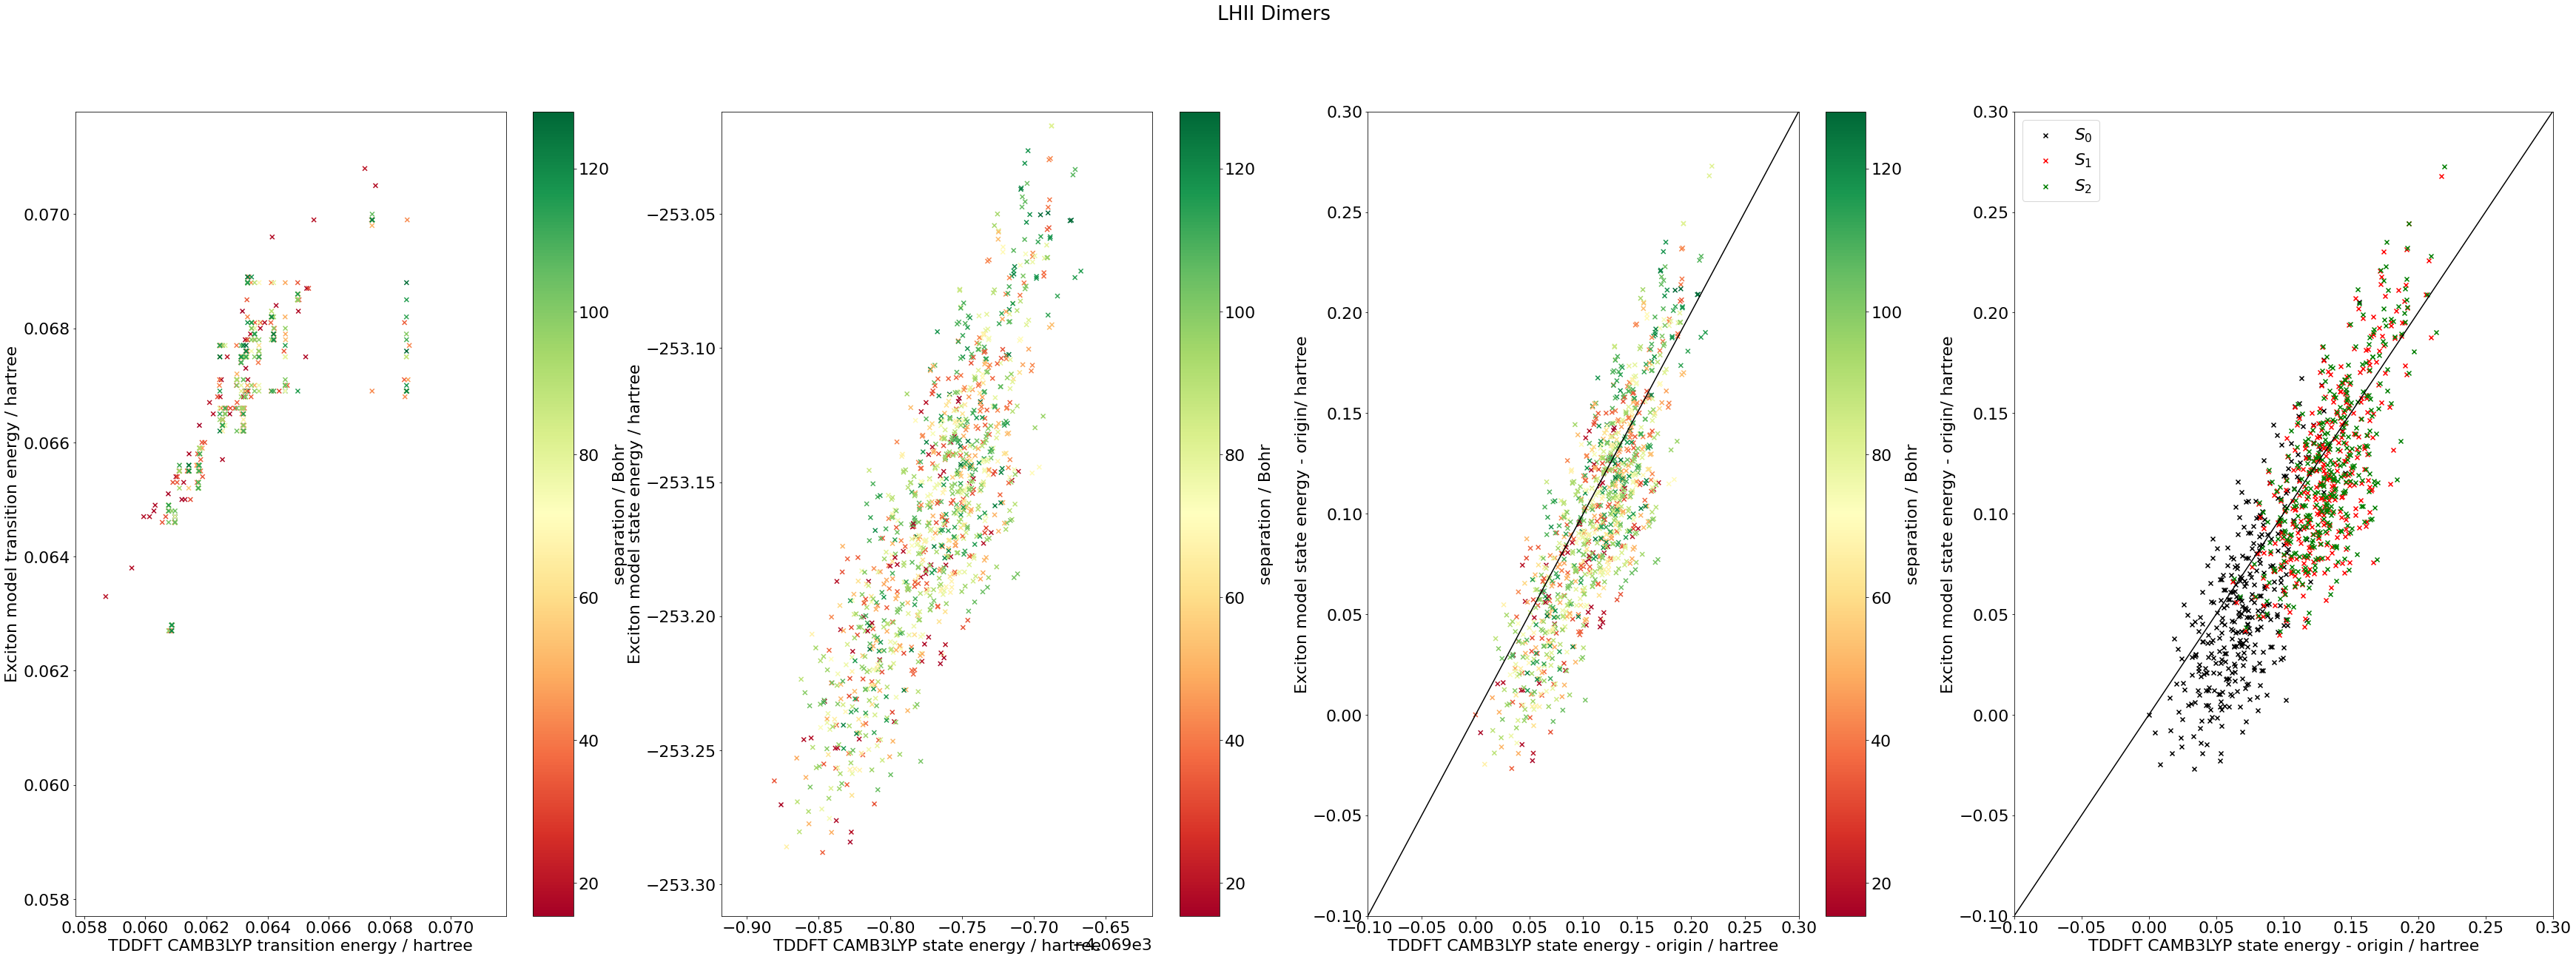

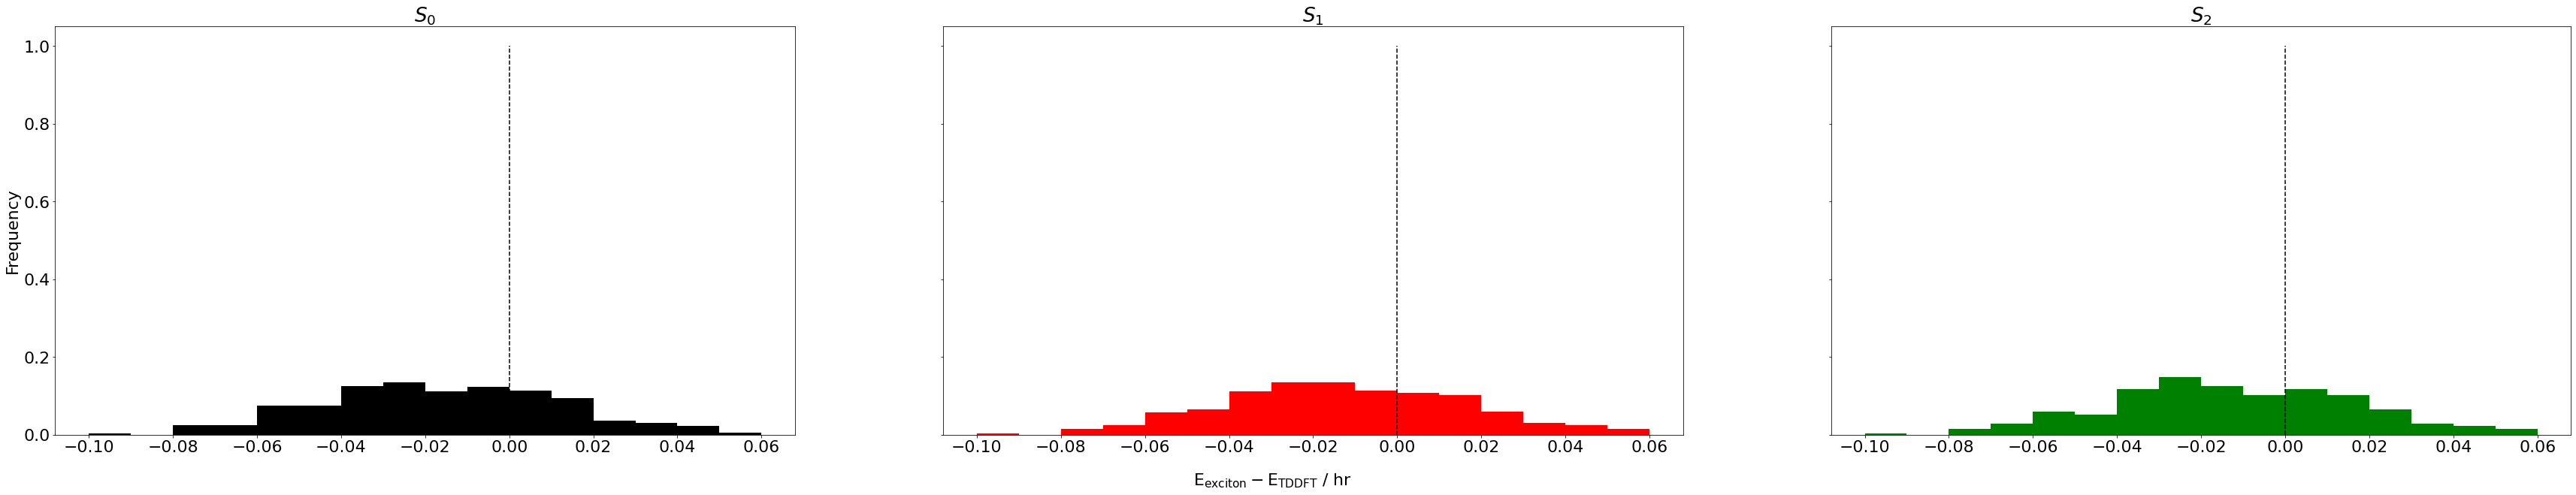

In [175]:
fig, ax = plt.subplots(1, 4)

CAMB3LYP_transition_1 = get_values(LHII_dimers["CAMB3LYP transitions"], 0)
CAMB3LYP_transition_2 = get_values(LHII_dimers["CAMB3LYP transitions"], 1)

exciton_transition_1 = get_values(LHII_dimers["exciton transitions"], 0)
exciton_transition_2 = get_values(LHII_dimers["exciton transitions"], 1)

CAMB3LYP_ground_state = get_values(LHII_dimers["CAMB3LYP states"], 0)
CAMB3LYP_excited1_state = get_values(LHII_dimers["CAMB3LYP states"], 1)
CAMB3LYP_excited2_state = get_values(LHII_dimers["CAMB3LYP states"], 2)

exciton_ground_state = get_values(LHII_dimers["exciton states"], 0)
exciton_excited1_state = get_values(LHII_dimers["exciton states"], 1)
exciton_excited2_state = get_values(LHII_dimers["exciton states"], 2)

camb3lyp_transitions = np.concatenate((CAMB3LYP_transition_1, CAMB3LYP_transition_2))
exciton_transitions  = np.concatenate((exciton_transition_1, exciton_transition_2))

camb3lyp_states = np.concatenate((CAMB3LYP_ground_state, CAMB3LYP_excited1_state, CAMB3LYP_excited2_state))
exciton_states = np.concatenate((exciton_ground_state, exciton_excited1_state, exciton_excited2_state))

min_index = np.argmin(CAMB3LYP_ground_state)

camb3lyp_origin = CAMB3LYP_ground_state[min_index]
exciton_origin = exciton_ground_state[min_index]

CAMB3LYP_ground_state_relative   = np.array([x - camb3lyp_origin for x in CAMB3LYP_ground_state])
CAMB3LYP_excited1_state_relative = np.array([x - camb3lyp_origin for x in CAMB3LYP_excited1_state])
CAMB3LYP_excited2_state_relative = np.array([x - camb3lyp_origin for x in CAMB3LYP_excited2_state])

exciton_ground_state_relative   = np.array([x - exciton_origin for x in exciton_ground_state])
exciton_excited1_state_relative = np.array([x - exciton_origin for x in exciton_excited1_state])
exciton_excited2_state_relative = np.array([x - exciton_origin for x in exciton_excited2_state])

camb3lyp_states_relative = np.concatenate((CAMB3LYP_ground_state_relative, CAMB3LYP_excited1_state_relative, CAMB3LYP_excited2_state_relative))
exciton_states_relative  = np.concatenate((exciton_ground_state_relative, exciton_excited1_state_relative, exciton_excited2_state_relative))

all_distances = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"]))
all_distances3 = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"], LHII_dimers["distance"]))

state_numbers = np.concatenate(([0 for x in range(len(CAMB3LYP_ground_state_relative))], [1 for x in range(len(CAMB3LYP_excited1_state_relative))], [2 for x in range(len(CAMB3LYP_excited2_state_relative))]))

cax_transition = ax[0].scatter(camb3lyp_transitions, exciton_transitions,  c=all_distances, cmap='RdYlGn', marker='x')
cax_states = ax[1].scatter(camb3lyp_states, exciton_states,  c=all_distances3, cmap='RdYlGn', marker='x')
cax_relative = ax[2].scatter(camb3lyp_states_relative, exciton_states_relative, c=all_distances3, cmap='RdYlGn', marker='x')

ax[3].scatter(CAMB3LYP_ground_state_relative, exciton_ground_state_relative, marker='x', color='black', label="$S_0$")
ax[3].scatter(CAMB3LYP_excited1_state_relative, exciton_excited1_state_relative, marker='x', color='red', label="$S_1$")
ax[3].scatter(CAMB3LYP_excited2_state_relative, exciton_excited2_state_relative, marker='x', color='green', label="$S_2$")

max_transition = max(max(camb3lyp_transitions), max(exciton_transitions))
min_transition = min(min(camb3lyp_transitions), min(exciton_transitions))
padding = 0.001

ax[0].set_xlim(min_transition - padding, max_transition + padding)
ax[0].set_ylim(min_transition - padding, max_transition + padding)

exciton_average = np.mean(camb3lyp_states)
camb3lyp_average = np.mean(exciton_states)

ax[1].set_ylim(camb3lyp_average-0.15, camb3lyp_average+0.15)
ax[1].set_xlim(exciton_average-0.15, exciton_average+0.15)


rel_min = -.1
rel_max = 0.3

ax[2].plot([rel_min, rel_max], [rel_min, rel_max], color='black')
ax[2].set_xlim(rel_min, rel_max)
ax[2].set_ylim(rel_min, rel_max)

ax[3].plot([rel_min, rel_max], [rel_min, rel_max], color='black')
ax[3].set_xlim(rel_min, rel_max)
ax[3].set_ylim(rel_min, rel_max)

#p = np.polyfit(camb3lyp_transitions, exciton_transitions, deg=1)

#line_of_best_fit = lambda x : p[0] * x + p[1]

#ax[0].plot([min_transition, max_transition], [line_of_best_fit(x) for x in [min_transition-padding, max_transition+padding]], color='black')

ax[0].set_xlabel("TDDFT CAMB3LYP transition energy / hartree")
ax[0].set_ylabel("Exciton model transition energy / hartree")

ax[1].set_xlabel("TDDFT CAMB3LYP state energy / hartree")
ax[1].set_ylabel("Exciton model state energy / hartree")

ax[2].set_xlabel("TDDFT CAMB3LYP state energy - origin / hartree")
ax[2].set_ylabel("Exciton model state energy - origin/ hartree")

ax[3].set_xlabel("TDDFT CAMB3LYP state energy - origin / hartree")
ax[3].set_ylabel("Exciton model state energy - origin/ hartree")
ax[3].legend()

cbar_transition = fig.colorbar(cax_transition, ax=ax[0])
cbar_transition.set_label("separation / Bohr")

cbar_states = fig.colorbar(cax_states, ax=ax[1])
cbar_states.set_label("separation / Bohr")

cbar_relative = fig.colorbar(cax_relative, ax=ax[2])
cbar_relative.set_label("separation / Bohr")

fig.suptitle("LHII Dimers")

fig.set_size_inches(60, 20)

### Histograms
fig2, ax2 = plt.subplots(1, 3, sharex=True, sharey=True)

bins = np.linspace(-.1, 0.06, 17)

density = False
n0, _, _ = ax2[0].hist(exciton_ground_state_relative - CAMB3LYP_ground_state_relative, color='green', bins=bins, density = density)
n1, _, _ = ax2[1].hist(exciton_excited1_state_relative - CAMB3LYP_excited1_state_relative, color='orange', bins=bins, density = density)
n2, _, _ = ax2[2].hist(exciton_excited2_state_relative - CAMB3LYP_excited2_state_relative, color='red', bins=bins, density = density)

ax2[0].clear()
ax2[1].clear()
ax2[2].clear()

total = np.sum(n0)

ax2[0].bar(bins[:-1], n0/total, color='black', width= 0.01, align='edge')
ax2[1].bar(bins[:-1], n1/total, color='red', width = 0.01, align='edge')
ax2[2].bar(bins[:-1], n2/total, color='green', width = 0.01, align='edge')

ax2[0].set_title("$S_0$")
ax2[1].set_title("$S_1$")
ax2[2].set_title("$S_2$")

ax2[0].vlines([0], ymin=0, ymax=1, linestyle='--')
ax2[1].vlines([0], ymin=0, ymax=1, linestyle='--')
ax2[2].vlines([0], ymin=0, ymax=1, linestyle='--')

ax2[0].set_ylabel("Frequency")
fig2.text(0.5, 0.04, "$\mathrm{E}_\mathrm{exciton} - \mathrm{E}_\mathrm{TDDFT}$ / hr ", ha='center', va='center')

fig2.set_size_inches(60, 10)

## Average error

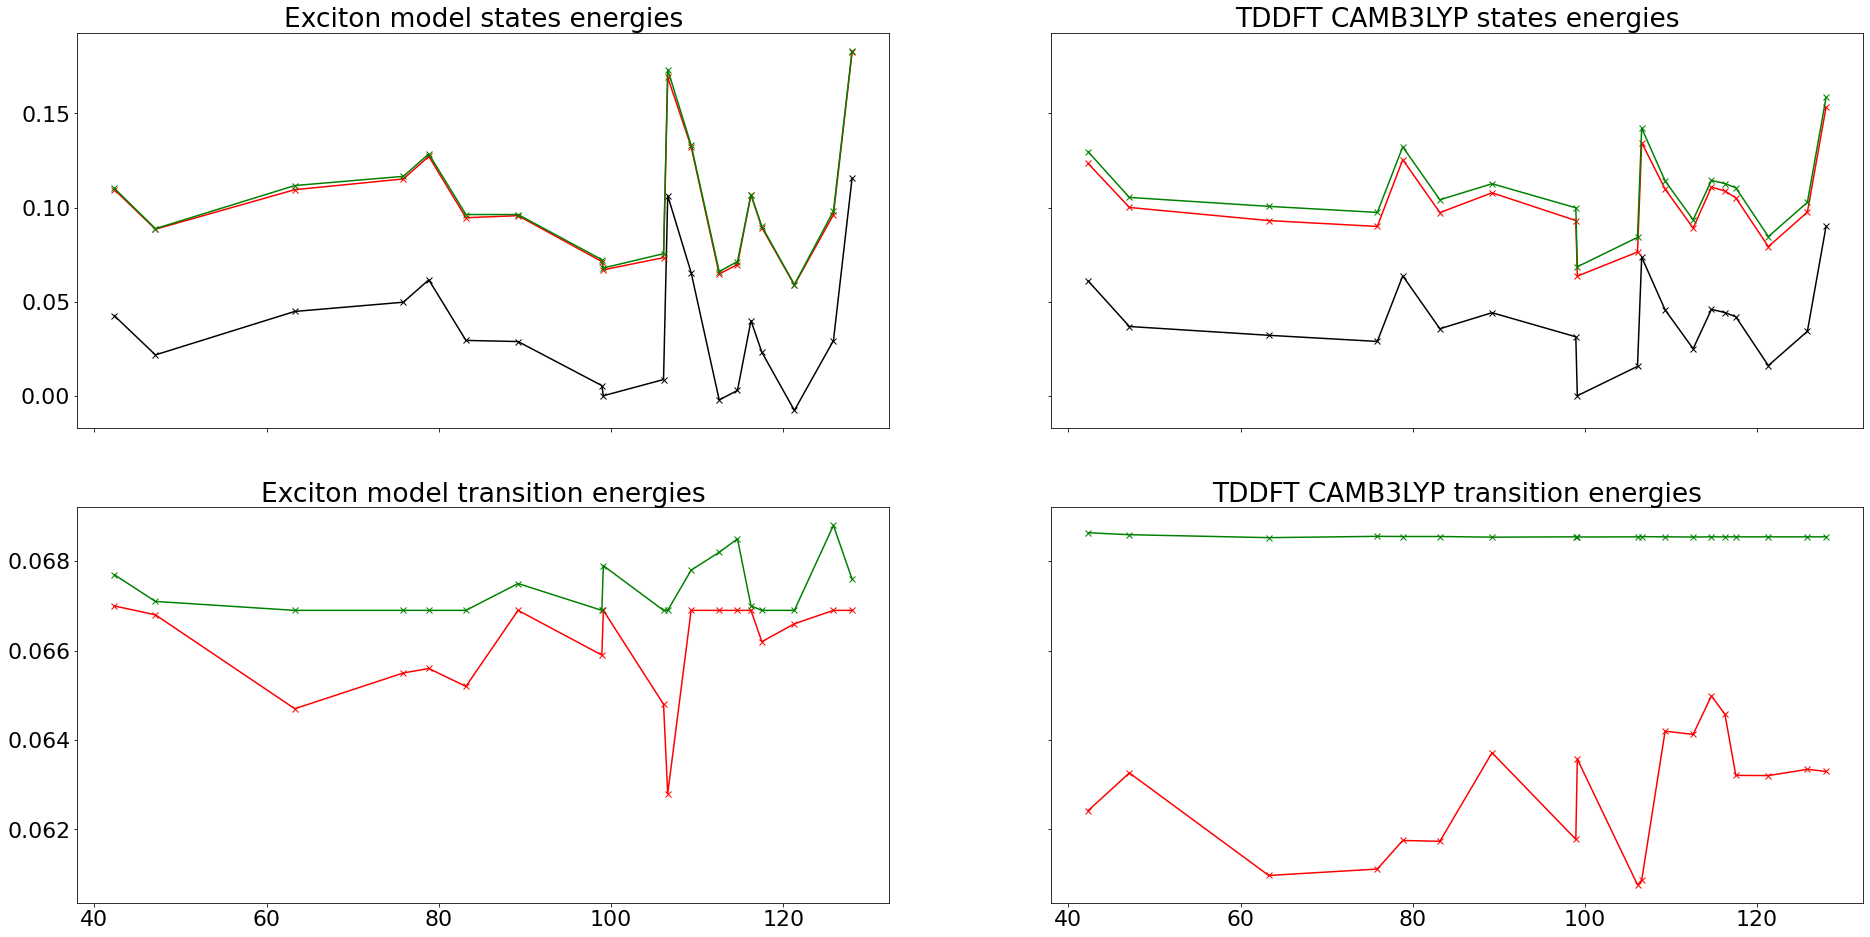

In [179]:
def one_chromophore(df, index):
    
    return df[df["monomer B"] == index]

fig, axes = plt.subplots(2, 2, sharex = True, sharey = 'row')

ax = axes.ravel()

chromophore_20 = one_chromophore(LHII_dimers, 20)

chromophore_20 = chromophore_20.sort_values(by="distance")

exciton_c20_ground = get_values(chromophore_20["exciton states"], 0)
exciton_c20_excited1 = get_values(chromophore_20["exciton states"], 1)
exciton_c20_excited2 = get_values(chromophore_20["exciton states"], 2)

CAMB3LYP_c20_ground = get_values(chromophore_20["CAMB3LYP states"], 0)
CAMB3LYP_c20_excited1 = get_values(chromophore_20["CAMB3LYP states"], 1)
CAMB3LYP_c20_excited2 = get_values(chromophore_20["CAMB3LYP states"], 2)

exciton_c20_transition1 = get_values(chromophore_20["exciton transitions"], 0)
exciton_c20_transition2 = get_values(chromophore_20["exciton transitions"], 1)

CAMB3LYP_c20_transition1 = get_values(chromophore_20["CAMB3LYP transitions"], 0)
CAMB3LYP_c20_transition2 = get_values(chromophore_20["CAMB3LYP transitions"], 1)

min_index = np.argmin(CAMB3LYP_c20_ground)
exciton_origin  = exciton_c20_ground[min_index]
camb3lyp_origin = CAMB3LYP_c20_ground[min_index]

exciton_c20_ground_relative    = exciton_c20_ground - exciton_origin
exciton_c20_excited1_relative  = exciton_c20_excited1 - exciton_origin
exciton_c20_excited2_relative  = exciton_c20_excited2 - exciton_origin

CAMB3LYP_c20_ground_relative   = CAMB3LYP_c20_ground - camb3lyp_origin
CAMB3LYP_c20_excited1_relative = CAMB3LYP_c20_excited1 - camb3lyp_origin
CAMB3LYP_c20_excited2_relative = CAMB3LYP_c20_excited2 - camb3lyp_origin

distances = chromophore_20["distance"]

ax[0].plot(distances, exciton_c20_ground_relative, marker='x', color='black')
ax[0].plot(distances, exciton_c20_excited1_relative, marker='x', color='red')
ax[0].plot(distances, exciton_c20_excited2_relative, marker='x', color='green')

ax[1].plot(distances, CAMB3LYP_c20_ground_relative, marker='x', color='black')
ax[1].plot(distances, CAMB3LYP_c20_excited1_relative, marker='x', color='red')
ax[1].plot(distances, CAMB3LYP_c20_excited2_relative, marker='x', color='green')

ax[2].plot(distances, exciton_c20_transition1, marker='x', color='red')
ax[2].plot(distances, exciton_c20_transition2, marker='x', color='green')

ax[3].plot(distances, CAMB3LYP_c20_transition1, marker='x', color='red')
ax[3].plot(distances, CAMB3LYP_c20_transition2, marker='x', color='green')

ax[0].set_title("Exciton model states energies")
ax[1].set_title("TDDFT CAMB3LYP states energies")
ax[2].set_title("Exciton model transition energies")
ax[3].set_title("TDDFT CAMB3LYP transition energies")

fig.set_size_inches(32, 16)

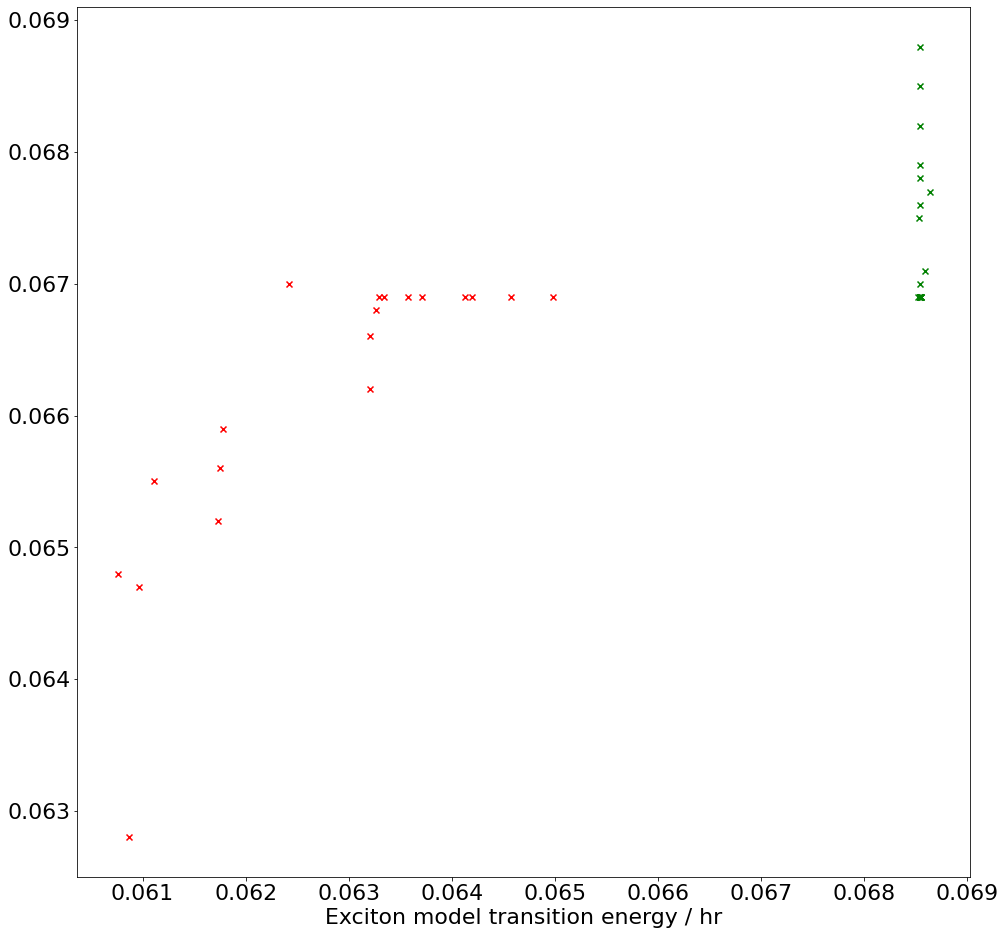

In [180]:
fig, ax = plt.subplots()

ax.scatter(CAMB3LYP_c20_transition1, exciton_c20_transition1, marker='x', color='red')
ax.scatter(CAMB3LYP_c20_transition2, exciton_c20_transition2, marker='x', color='green')

ax.set_xlabel("TDDFT CAMB3LYP transition energy / hr")
ax.set_xlabel("Exciton model transition energy / hr")

fig.set_size_inches(16,16)

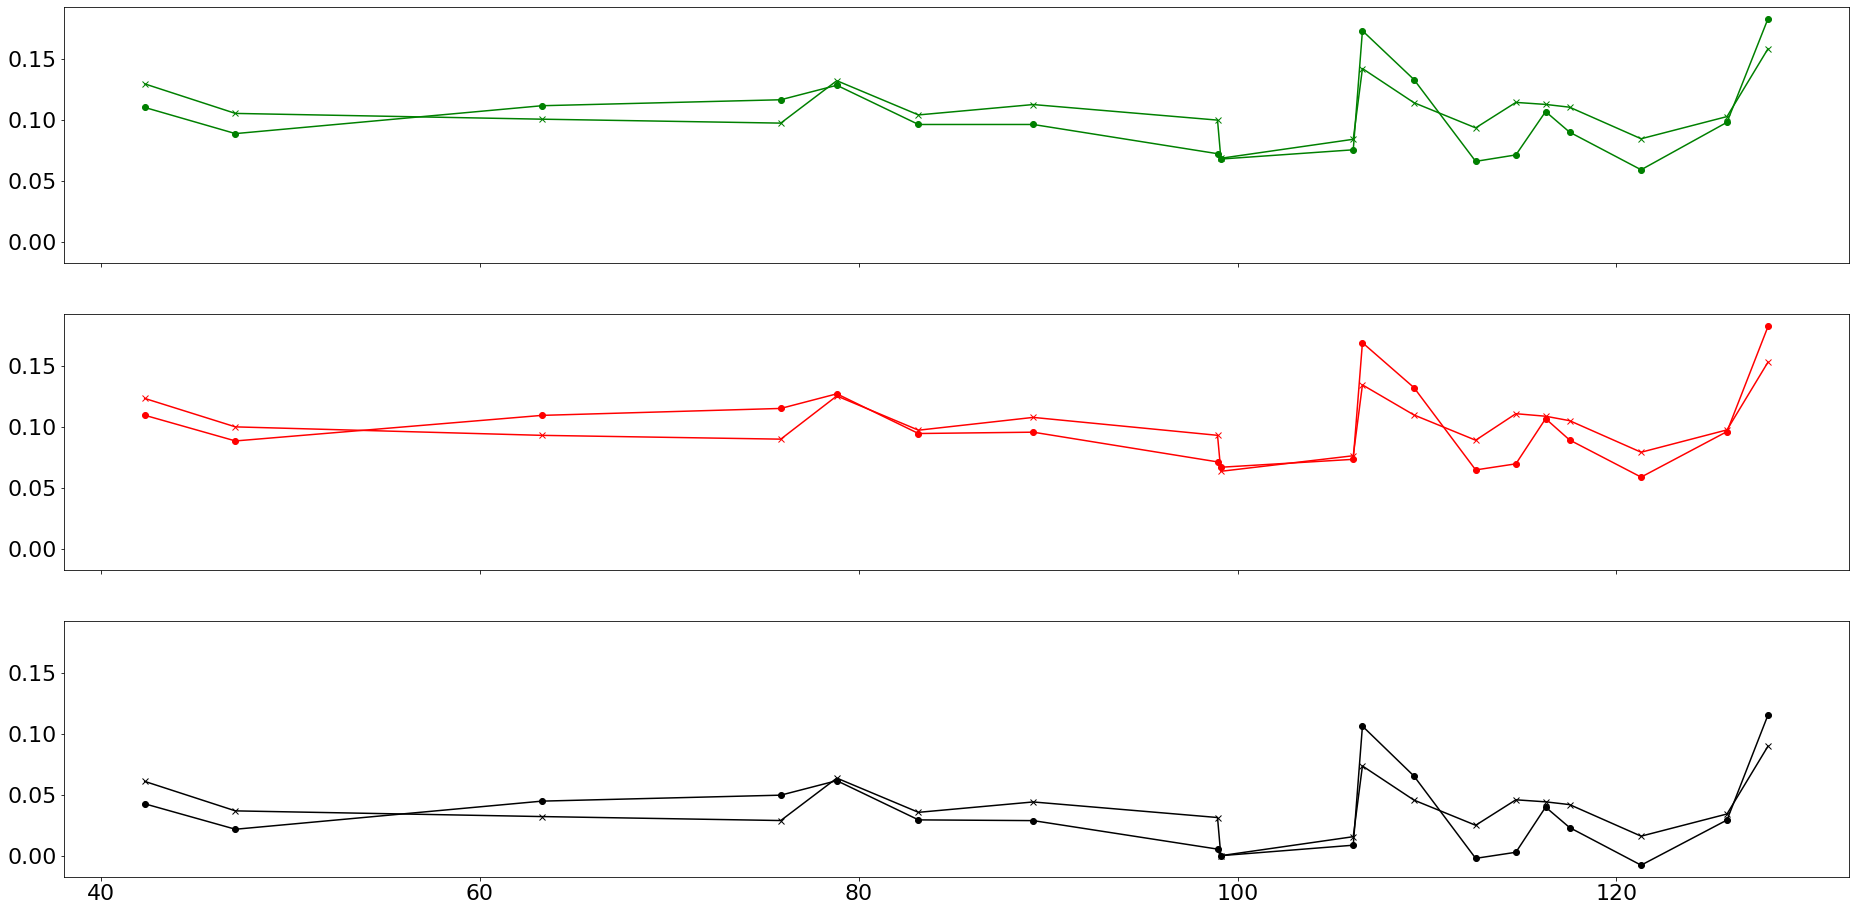

In [116]:
fig, ax = plt.subplots(3, 1)

ax[2].plot(distances, exciton_c20_ground_relative, color='black', marker='o')
ax[1].plot(distances, exciton_c20_excited1_relative, color='red', marker='o')
ax[0].plot(distances, exciton_c20_excited2_relative, color='green', marker='o')

ax[2].plot(distances, CAMB3LYP_c20_ground_relative,   color='black', marker='x')
ax[1].plot(distances, CAMB3LYP_c20_excited1_relative, color='red', marker='x')
ax[0].plot(distances, CAMB3LYP_c20_excited2_relative, color='green', marker='x')

fig.set_size_inches(32,16)

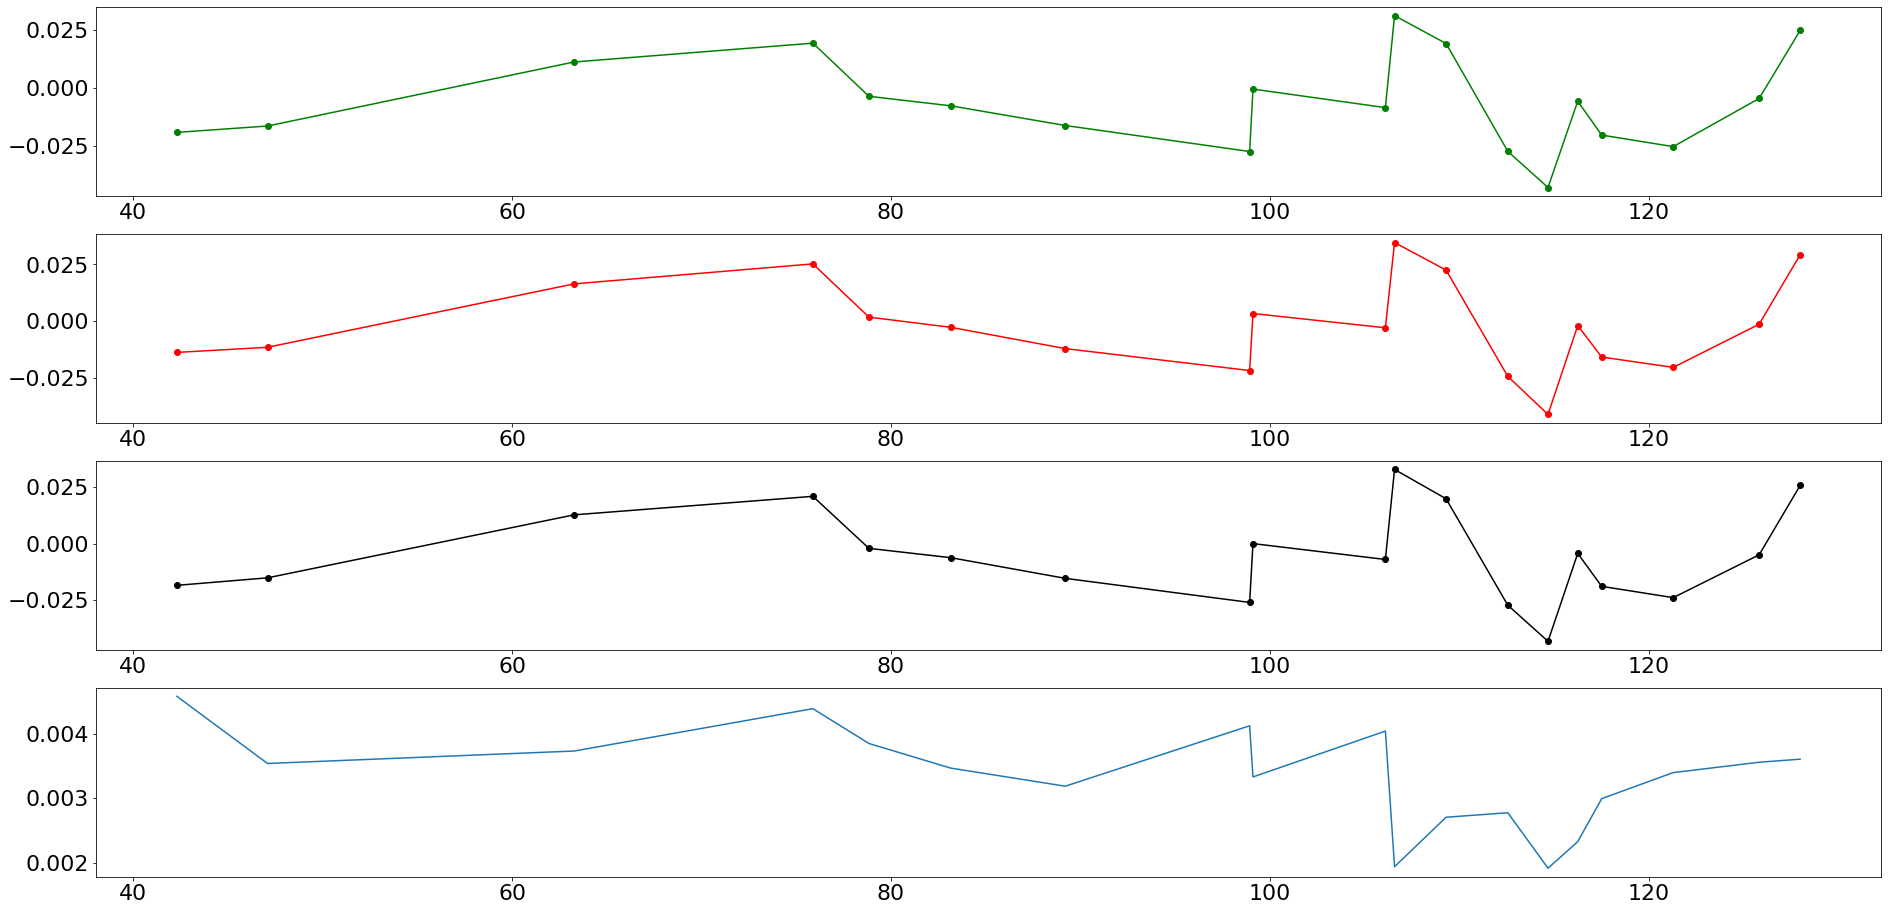

In [118]:
fig, ax = plt.subplots(4, 1)

ax[2].plot(distances, exciton_c20_ground_relative - CAMB3LYP_c20_ground_relative, color='black', marker='o')
ax[1].plot(distances, exciton_c20_excited1_relative - CAMB3LYP_c20_excited1_relative, color='red', marker='o')
ax[0].plot(distances, exciton_c20_excited2_relative - CAMB3LYP_c20_excited2_relative, color='green', marker='o')

ax[3].plot(distances, (exciton_c20_excited1_relative - CAMB3LYP_c20_excited1_relative) - (exciton_c20_ground_relative - CAMB3LYP_c20_ground_relative))

fig.set_size_inches(32,16)

## Ring interactions

In [20]:
def split_by_rings(df):
    B800_B800 = df.loc[(df["ring A"] == "B800") & (df["ring B"] == "B800")]

    B850_B850 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B850a", "B850b"]))]

    B850_B800 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B800"]))]
    B800_B850 = df.loc[(df["ring A"].isin(["B800"])) & (df["ring B"].isin(["B850a", "B850b"]))]
    
    return B800_B800, B850_B850, pd.concat([B850_B800, B800_B850])

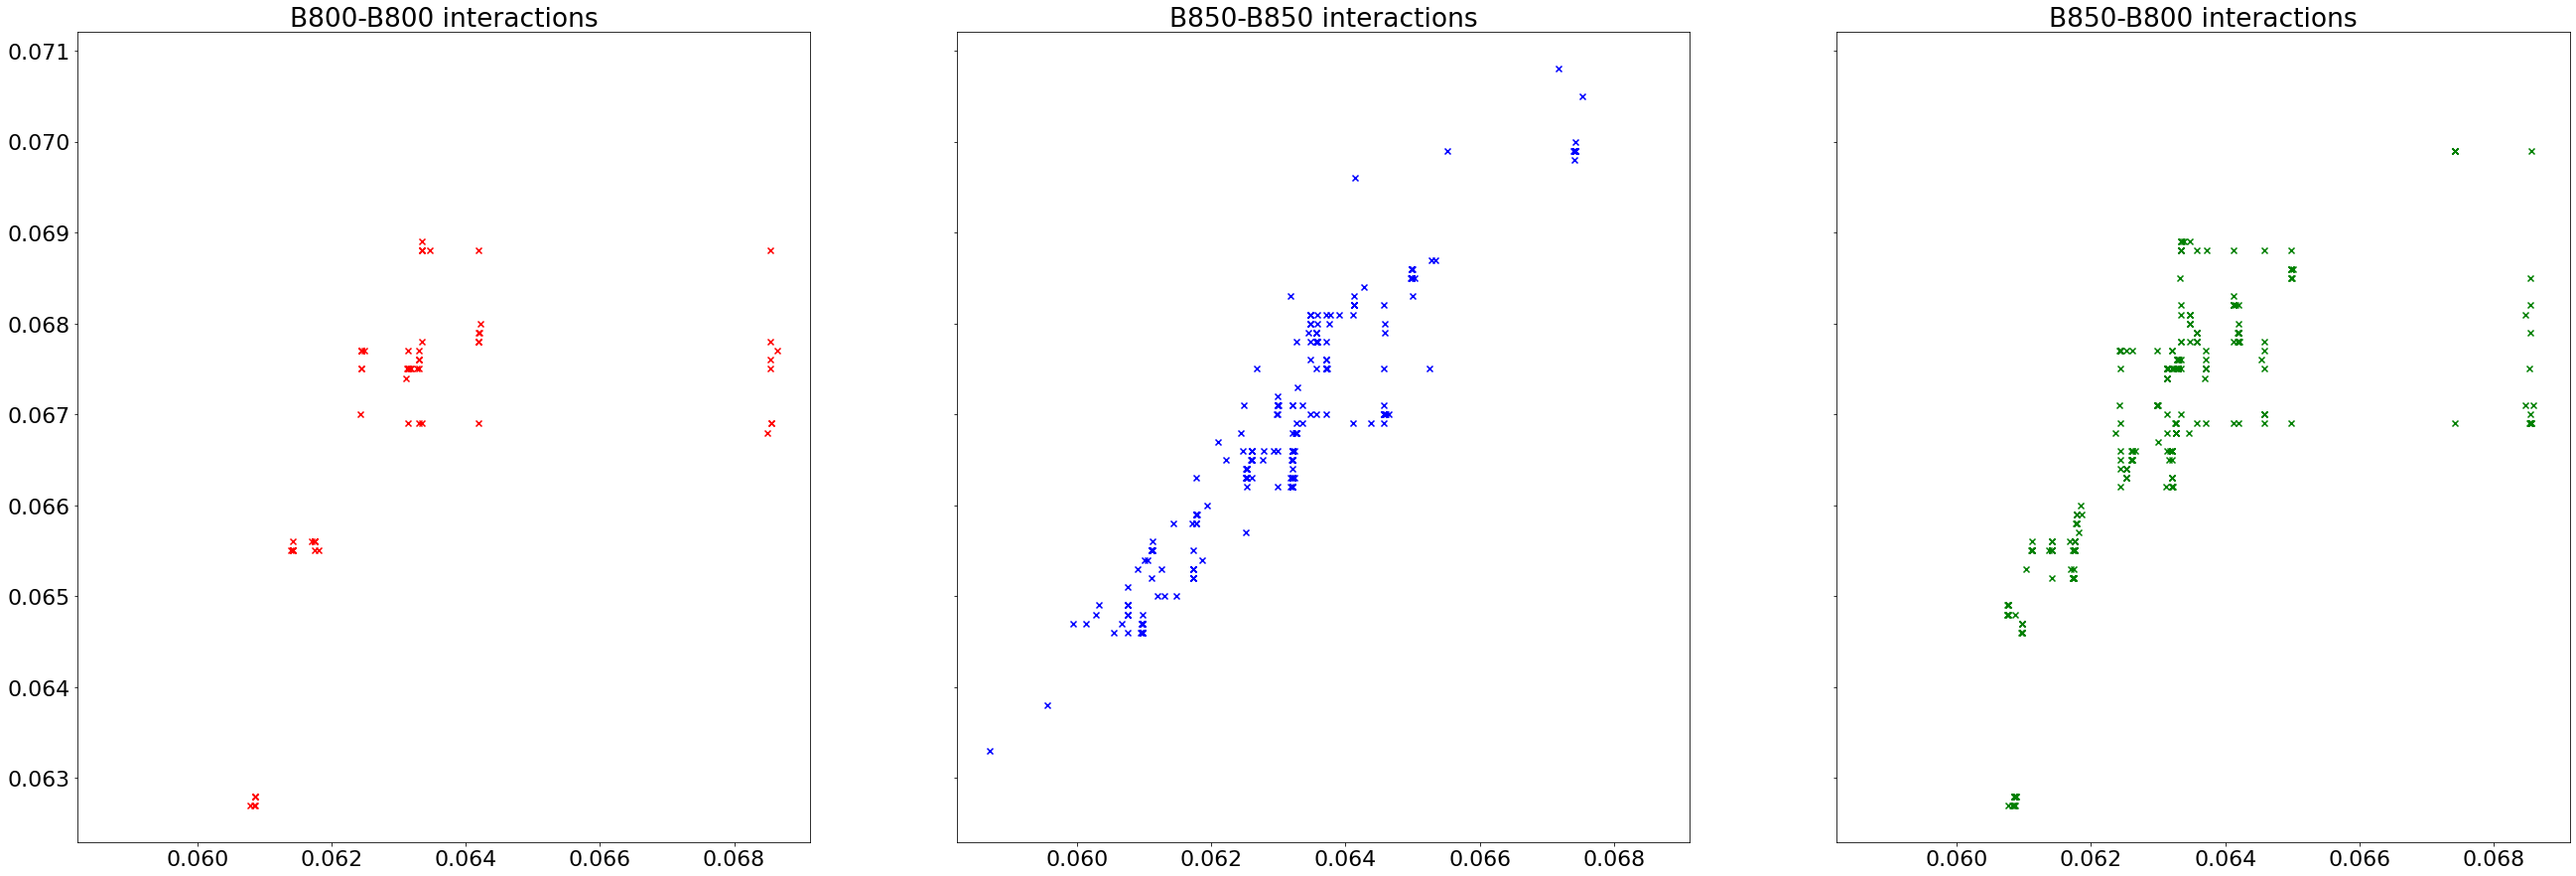

In [21]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)

B800_B800, B850_B850, B850_B800 = split_by_rings(LHII_dimers)

B800_B800_camb3lyp = np.concatenate((get_values(B800_B800["CAMB3LYP transitions"], 0), get_values(B800_B800["CAMB3LYP transitions"], 1)))
B800_B800_excitons = np.concatenate((get_values(B800_B800["exciton transitions"], 0), get_values(B800_B800["exciton transitions"], 1)))

B850_B850_camb3lyp = np.concatenate((get_values(B850_B850["CAMB3LYP transitions"], 0), get_values(B850_B850["CAMB3LYP transitions"], 1)))
B850_B850_excitons = np.concatenate((get_values(B850_B850["exciton transitions"], 0), get_values(B850_B850["exciton transitions"], 1)))

B850_B800_camb3lyp = np.concatenate((get_values(B850_B800["CAMB3LYP transitions"], 0), get_values(B850_B800["CAMB3LYP transitions"], 1)))
B850_B800_excitons = np.concatenate((get_values(B850_B800["exciton transitions"], 0), get_values(B850_B800["exciton transitions"], 1)))

ax[0].scatter(B800_B800_camb3lyp, B800_B800_excitons, marker='x', color='red')
ax[1].scatter(B850_B850_camb3lyp, B850_B850_excitons, marker='x', color='blue')
ax[2].scatter(B850_B800_camb3lyp, B850_B800_excitons, marker='x', color='green')

ax[0].set_title("B800-B800 interactions")
ax[1].set_title("B850-B850 interactions")
ax[2].set_title("B850-B800 interactions")

fig.set_size_inches(45, 15)

# Exciton coupling

In [22]:
full_LHII_dimers

,monomer A,monomer B,ring A,ring B,frame,distance,charge_centre_distance,coupling,exciton states,exciton transitions,CAMB3LYP states,CAMB3LYP transitions,CAMB3LYP present
0,23,26,B800,B800,30001,42.160708,40.8740,40.6102,"[-253.1937, -253.1267, -253.1257]","[0.067, 0.068]","[None, None, None]","[None, None]",False
1,10,13,B850a,B850a,43201,30.721072,31.8796,79.2057,"[-253.2543, -253.188, -253.1862]","[0.0663, 0.0681]","[None, None, None]","[None, None]",False
2,10,11,B850a,B800,19701,47.055558,44.6698,19.1131,"[-253.2075, -253.1402, -253.1399]","[0.0673, 0.0676]","[None, None, None]","[None, None]",False
3,1,7,B850a,B850a,15001,61.398402,61.8578,7.8413,"[-253.2166, -253.1481, -253.1475]","[0.0685, 0.0691]","[None, None, None]","[None, None]",False
4,10,13,B850a,B850a,47701,32.022734,32.4520,72.1146,"[-253.1385, -253.0731, -253.0705]","[0.0654, 0.068]","[None, None, None]","[None, None]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5527,10,11,B850a,B800,41201,48.284840,45.7726,15.0221,"[-253.199, -253.1332, -253.1314]","[0.0658, 0.0676]","[None, None, None]","[None, None]",False
5528,15,27,B850b,B850b,1,99.423275,97.3172,0.2866,"[-253.2327, -253.1663, -253.1652]","[0.0664, 0.0675]","[-4069.83662737, -4069.7741021048537, -4069.772911427417]","[0.06252526514622547, 0.06371594258288805]",True
5529,8,14,B800,B800,30001,80.918164,79.4034,4.5779,"[-253.1674, -253.1003, -253.1001]","[0.0671, 0.0673]","[None, None, None]","[None, None]",False
5530,10,12,B850a,B850b,42201,18.339184,17.0669,348.3975,"[-253.2297, -253.1646, -253.1613]","[0.0651, 0.0684]","[None, None, None]","[None, None]",False


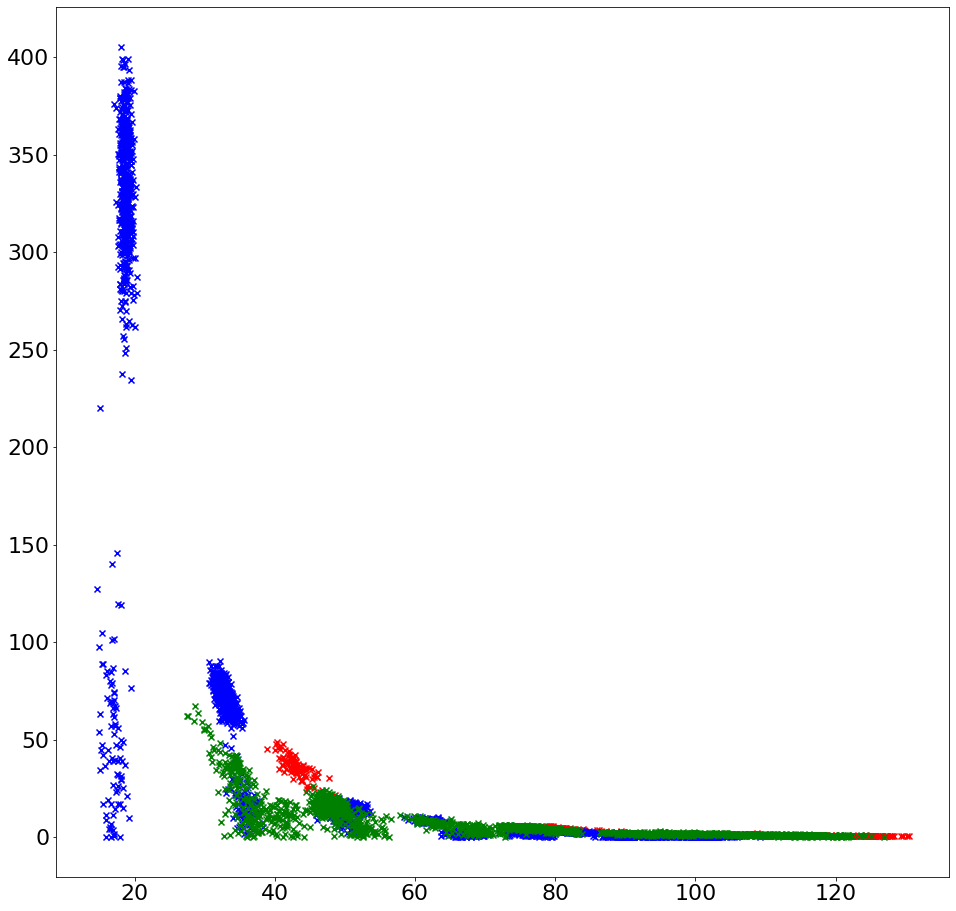

In [23]:
fig, ax = plt.subplots()

B800_B800, B850_B850, B850_B800 = split_by_rings(full_LHII_dimers)

ax.scatter(B800_B800["distance"], B800_B800["coupling"], marker='x', color='red')
ax.scatter(B850_B850["distance"], B850_B850["coupling"], marker='x', color='blue')
ax.scatter(B850_B800["distance"], B850_B800["coupling"], marker='x', color='green')

fig.set_size_inches(16, 16)